In [1]:
from bs4 import BeautifulSoup
import pandas as pd 
import os
import requests
import random
import re

# Getting the Songs (Name and Artist)

The whole data collection pipeline begins with a manual collection of Spotify playlists URLs in which we'd like to include in our dataset. Spotify was picked simply because I had a subscription to it, we could very much have done this through any other channels.

Our goal here is to get around 5000~ songs (name and artist) to begin with from these playlists, which since a lot of playlists have 500-1000 songs on them, it only takes around 10-15 playlists to get this. So I will just pick around 15 playlists from the search results to scrape from.

The steps we'll take:

1. Manually have a list of playlist URLs
2. Get temporary read API token from Spotify API, there's a 100 results limit
3. For each playlist, get 100 songs at a time and pour it into our list in memory


##### We may run into the same songs from different playlists, given that a lot of the "Classics" are pretty commonly included in everyone's playlists. This is not an issue because if it's popular then it "represents more" on Cantopop, and so having them across the dataset would capture this representation more, which is more than fine!

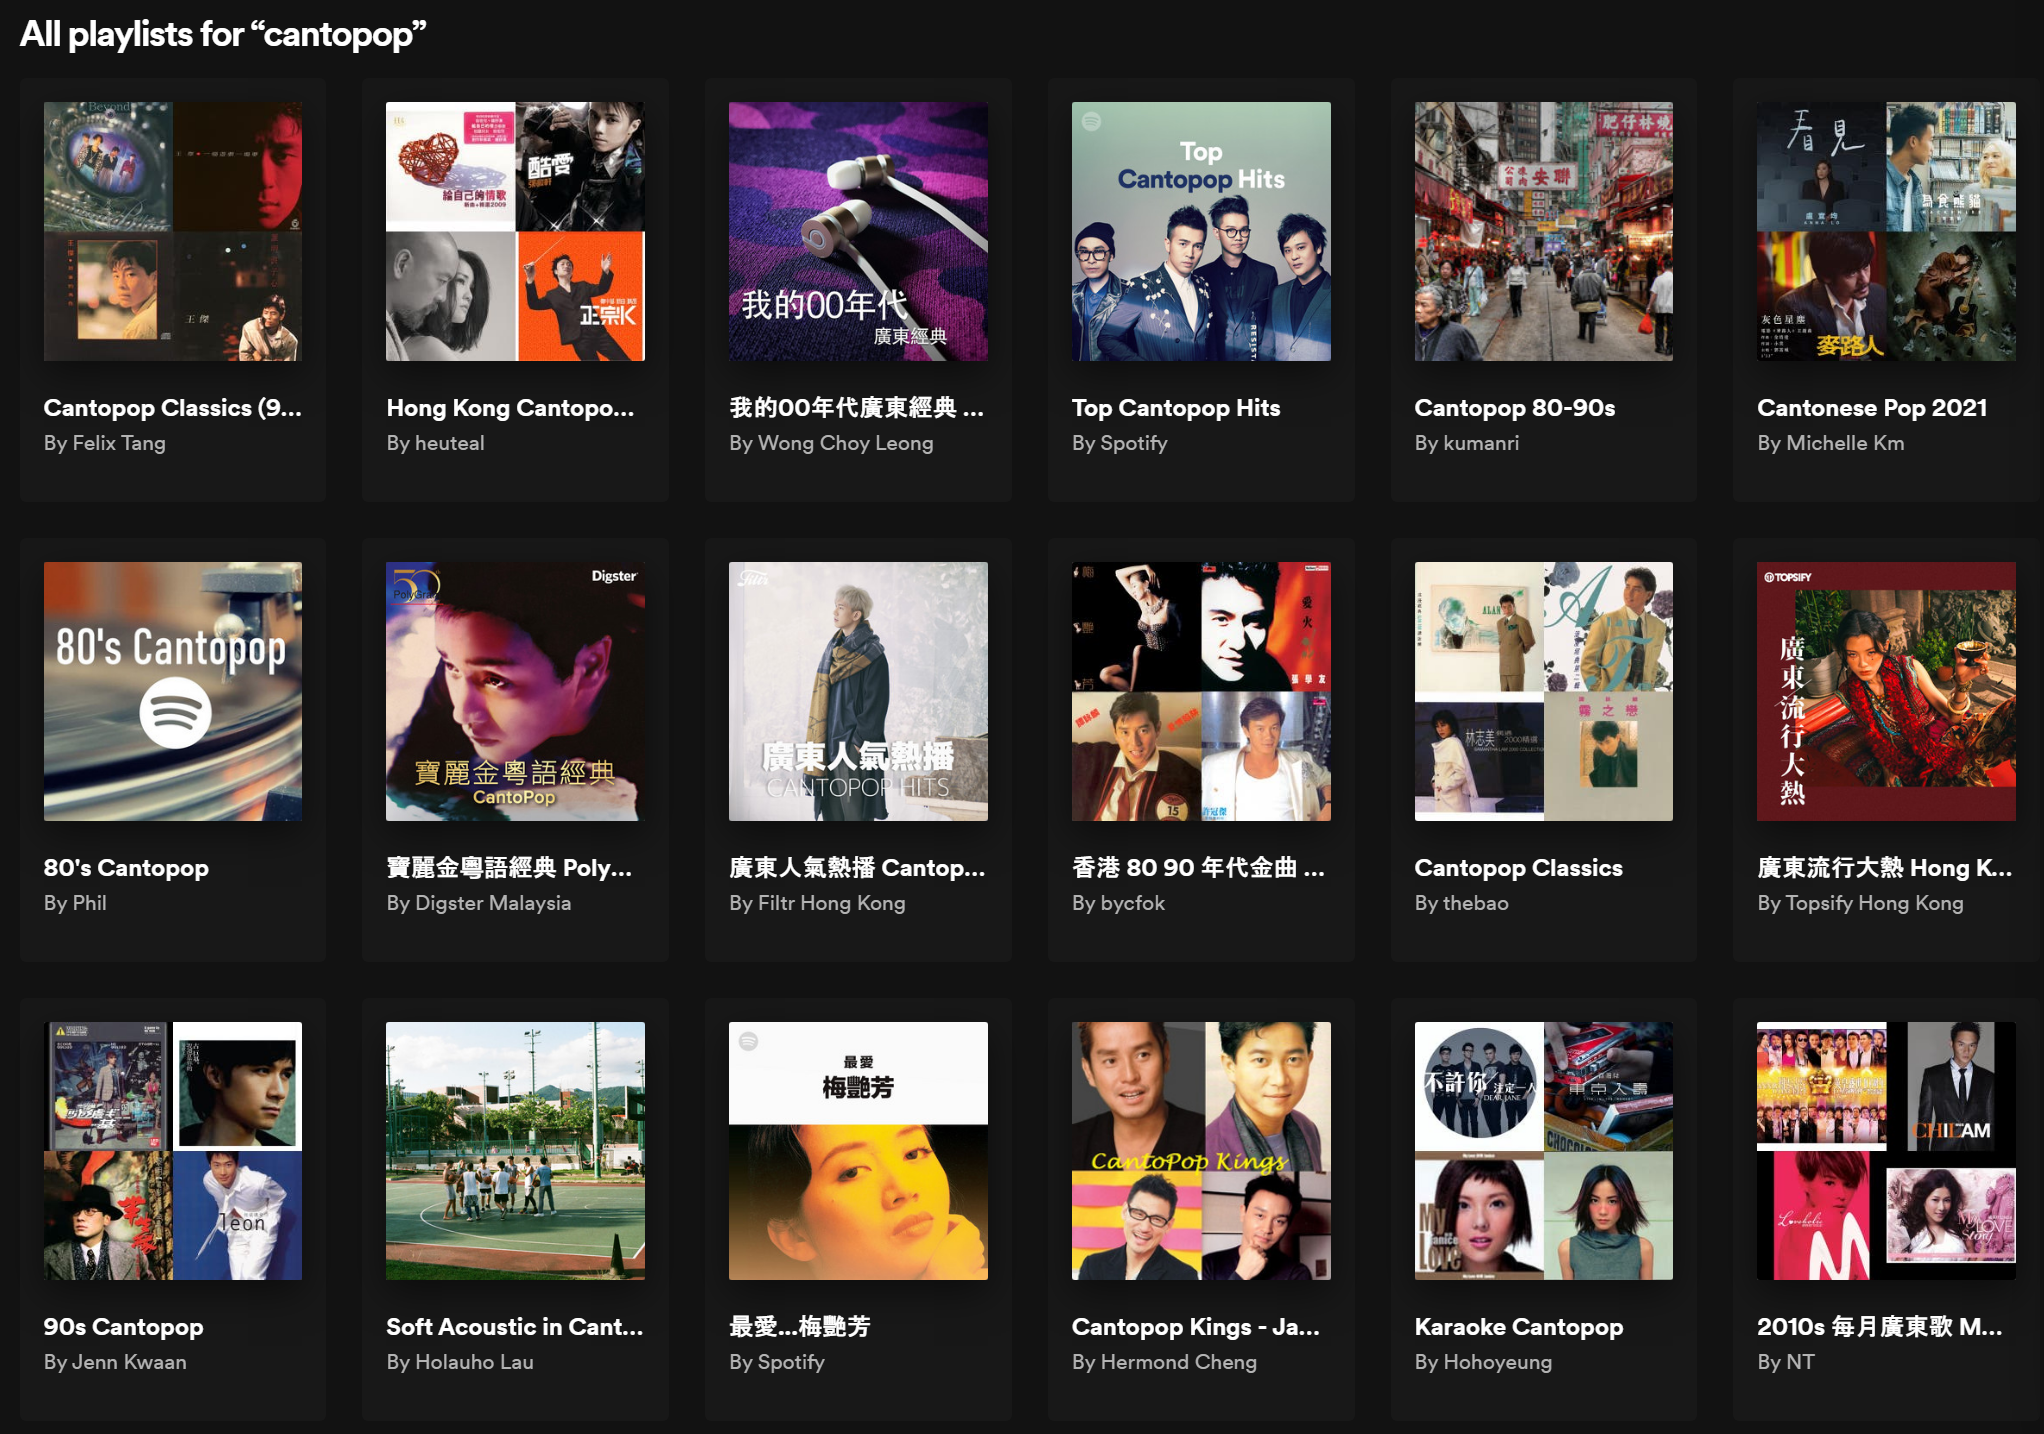

In [2]:
def getSongList(token, playlist_url):
    headers = {
        'Authorization': 'Bearer {}'.format(token)
    }

    BASE_URL = 'https://api.spotify.com/v1/playlists/{}/tracks?offset={}'
    
    PLAYLIST_URI = playlist_url.split('/')[4].split('?')[0]

    final_result = []
    
    totalSongs = int(requests.get(BASE_URL.format(PLAYLIST_URI, '0'), headers=headers).json()['total'])

    for offset in range(0, (totalSongs//100+1) * 100, 100):
        try:
            r = requests.get(BASE_URL.format(PLAYLIST_URI, offset), headers=headers)
            results = r.json()['items']
            final_result += (list(map(lambda x : {"name": x['track']['name'].split('-')[0].split('(')[0], "artist": x['track']['artists'][0]['name']} , results)))
            
        except Exception as e:
            print(f'Error getting song name/artist: {e}')
    
    print('{} songs were added from {}.'.format(len(final_result), playlist_url))
    return final_result

# Scrape KKBox for Link

Once we have the list of songs, we need two things: 1) The link to the lyrics of the song 2) The actual lyrics of the song. For this purpose, KKBox (an app similar to Spotify popular in APAC) has publicly accessible lyrics on their website. The plan therefore will be to:

1. Perform search on their website based on song name.
2. Return the link to the lyrics of the song for the "Top Result".
3. Scrape the link of the song for lyrics.

##### There are cases where the same song name may refer to different songs for different artists, but here we will just pick the Top Result everytime as the search interface doesn't work well with searches of "Song Name + Artist". This shouldn't too big of an issue as we're just trying to get the most popular songs as well.

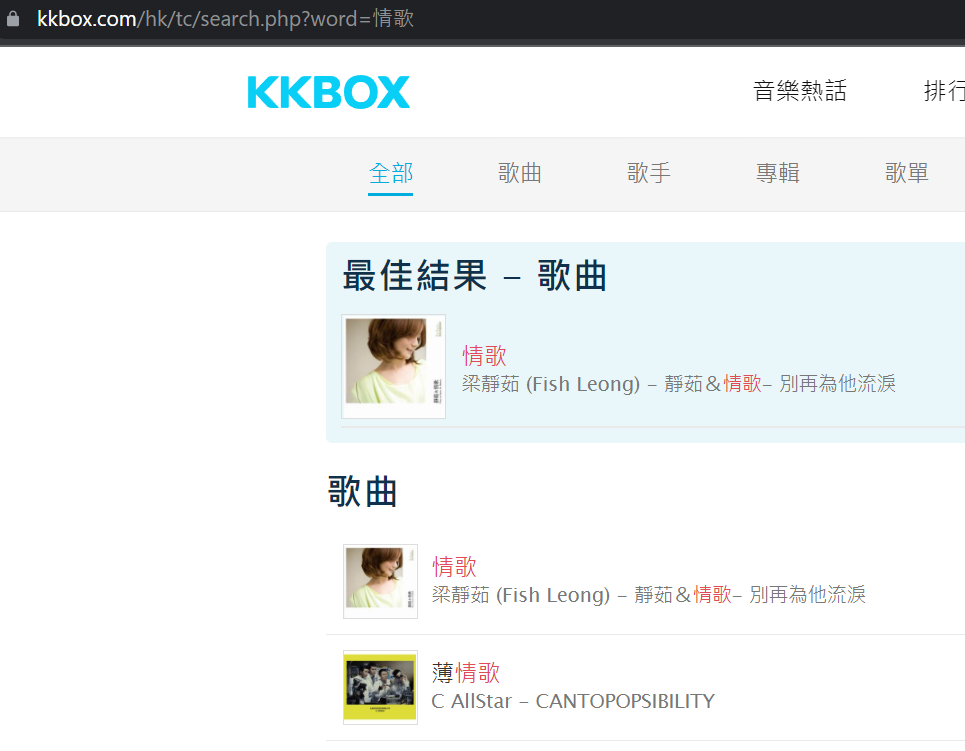


In [4]:
# Some rows we don't want to get right of the bat, just filter these rows out.
def rowFilter(row):
    if '演唱' in row:
        return False
    if '作詞' in row:
        return False
    if '作曲' in row:
        return False
    if 'Lyricist' in row:
        return False
    if 'Composer'  in row:
        return False
    if '間奏' in row:
        return False
    if '編' in row:
        return False
    if '監' in row:
        return False
    if '曲' in row:
        return False
    
    return True

# Some initial data cleaning first to get rid of stuff we certainly don't want.
def replaceKeywords(lyrics):
    wordsToReplace = {" " : "", 
                      "</>" : "", 
                      "<br/>" : "\n",
                      "<p>": "",
                      "</p>": "",
                      '<divclass="lyrics">': "",
                      '</div>' : "",
                      '(女)': '',
                      '(男)': '',
                      '(合)': '',
                      '#': "",
                      '＃': '',
                      '(': '',
                      ')': '',
                      ',':'\t',
                      '’': '',
                      '!': '',
                      '…': '',
                      '＊': '',
                      '*': '',
                      "（": '',
                      "'":"",
                      '...':'',
                      '☆':'',
                      '詞：':'',
                      ':': '',
                      '/':''
                     }
    result = lyrics
    for word in wordsToReplace.keys():
        result = result.replace(word, wordsToReplace[word])
    
    return result
    
    
# Get song KKBOX URL given a song object.
def getSongLinkFromKkbox(song):
    url = 'https://www.kkbox.com/hk/en/search.php?word={}'.format(song['name'])
    try:
        r = requests.get(url)
        pageContent = r.content 
    except Exception as e:
        print('Error requesting top results link {}'.format(e))

    soup = BeautifulSoup(r.content, 'html5lib')   
    try:
        link = 'https://www.kkbox.com/' + str(soup.find('a', attrs = {'class':'song-title'})).split('href=')[1].split('"')[1]
        return link
    except Exception as e:
        print('{} has no link, passing.'.format(song['name']))
        return None


# Get the actual lyrics given a KKBOX URL
def scrapeKkboxLink(link):
    try:
        r = requests.get(link)
        pageContent = r.content
    except Exception as e:
        print('Error requesting link during scraping {}'.format(e))
        
    soup = BeautifulSoup(r.content, 'html5lib')   
    lyrics = replaceKeywords(str(soup.find('div', attrs = {'class':'lyrics'})))
    lyrics = lyrics.split('\n')
    lyrics = [row for row in lyrics if rowFilter(row)]
    lyrics = '\n'.join(lyrics)
    lyrics = re.sub(r'[a-zA-z]', '', lyrics).replace('+','')

    return lyrics

# Initially if KKBOX doesn't contain lyrics, we could search another web as well, 
# but I've removed the other website scrape to reduce code complexity here.
def getLyrics(link):
    if link == None:
        return None
    
    if 'kkbox' in link:
        results = scrapeKkboxLink(link)
        if len(results.replace('\n','')) < 100:
            return None
        
        return results

    
    return None

# Putting It All Together

To make sure we have persistent storage of lyrics, it makes more sense to store it in a database rather than in main memory. I've chosen SQLite3 for its simplicity and SQL features makes things super easy to work with. So for each song, we get their lyrics and throw it into the SQLite3 db, a lot of data might be dirty but we'll clean them in a separate notebook.


In short:
1. Initialise SQLite3 database file.
2. Get all songs from Spotify playlist
3. For each song,
    - Search KKBox for top results
    - Return top result link for lyrics
    - Go to that link and scrape the lyrics
    - Flow lyrics through and save it for the song into a buffer list of lyrics
    
4. Once the buffer reaches 50 songs, insert all the lyrics into the SQLite3 db.


In [5]:
# Create an sqlite3 to store all the scraped lyrics
import sqlite3
import time

con = sqlite3.connect('ai_love_song.db')
cur = con.cursor()
sql_statements = []

In [21]:
def createDB():
    cur.execute('''CREATE TABLE IF NOT EXISTS lyrics (run_id text, name text, artist text, lyrics text)''')
    con.commit()

# add a add-song statement to database
def addStatement(sql):
    global sql_statements
    if len(sql_statements) > 50: # once there are 50 songs, bulk commit them to the db
        return pushTransaction()
    
    sql_statements.append(sql)

# commit and push statements to database
def pushTransaction():
    global sql_statements
    rows_added = 0
    rows_error = 0
    cur.execute('BEGIN TRANSACTION')
    for statement in sql_statements:
        try:
            cur.execute(statement)
            rows_added += 1
        except Exception as e:
            print('Row cannot be added because: ', e)
            rows_error += 1
            pass
    sql_statements = []
    con.commit()
    print("Transaction Completed: {} rows added ; {} rows error".format(rows_added, rows_error))
    
# given song name, run the process of adding an insert statement with the song info
def insertSong(runId, song):
    songUrl = getSongLinkFromKkbox(song)
    lyrics = getLyrics(songUrl)
    if lyrics == None:
        return False
    sql = '''INSERT INTO lyrics VALUES("{}", "{}", "{}", "{}") '''.format(runId, song['name'], song['artist'], lyrics)
    addStatement(sql)
    return True

# used for cleaning out bulks of data in case there are issues with the data
def deleteRun(runId):
    sql = '''DELETE FROM lyrics WHERE run_id={}'''.format(runId)
    cur.execute(sql)
    con.commit()

In [22]:
apiToken= 'BQAqO8O4XzJNR3WN8Riiy4ufJPt4CkINoLuJducu81QRs-U3pOyDG0F7026KlZqIhSmZLgev76FcXRDEIg0xl048oB_5SggG06M-HfziRyTfGH3yRkZo9c8kRlP7sfJee9SsG1qBgIvbFgZvU0OzhZo8Lcln1g'
test = getSongList(apiToken, 'https://open.spotify.com/playlist/38uFgdleiwHcs0tVmTwkdM?si=035f80a093fb41a6')

1085 songs were added from https://open.spotify.com/playlist/38uFgdleiwHcs0tVmTwkdM?si=035f80a093fb41a6.


In [23]:
# Create the databse first if not exist
createDB()

# A few playlists I picked to start with
playlists = [
    'https://open.spotify.com/playlist/4cd77a6cpcSyJJADQm3CaD?si=7fd714df40584946',
    'https://open.spotify.com/playlist/0xIfZKAKffK7Xw8kHl0uO1?si=690bbb31d288463a',
    'https://open.spotify.com/playlist/4YGjtvMmG7ePQr2SZt8U3I?si=9a64aa9320a248f7'
]


song_list = []
for playlist in playlists:
    song_list += getSongList(apiToken, playlist)

print('Song list now contains {} songs'.format(len(song_list)))

463 songs were added from https://open.spotify.com/playlist/4cd77a6cpcSyJJADQm3CaD?si=7fd714df40584946.
773 songs were added from https://open.spotify.com/playlist/0xIfZKAKffK7Xw8kHl0uO1?si=690bbb31d288463a.
1333 songs were added from https://open.spotify.com/playlist/4YGjtvMmG7ePQr2SZt8U3I?si=9a64aa9320a248f7.
Song list now contains 2569 songs


In [17]:
# deleteRun('1')

In [28]:
sql_statements = []

for count, song in enumerate(song_list):

    print('{} : Inserting {} by {}.....................'.format(count ,song['name'], song['artist']), end='\r')
    insertSong('4', song)
    time.sleep(0.5)

pushTransaction()
        
    

Transaction Completed: 51 rows added ; 0 rows error........
Transaction Completed: 51 rows added ; 0 rows error...........
Transaction Completed: 51 rows added ; 0 rows error...............
Transaction Completed: 51 rows added ; 0 rows error.............
Transaction Completed: 51 rows added ; 0 rows error......ng.....................
Row cannot be added because:  near "我愛你": syntax error......
Row cannot be added because:  near "真愛總會是永遠": syntax error
Transaction Completed: 49 rows added ; 2 rows error
Transaction Completed: 51 rows added ; 0 rows error...........
Transaction Completed: 51 rows added ; 0 rows error..............
Transaction Completed: 51 rows added ; 0 rows error.............
Transaction Completed: 51 rows added ; 0 rows error....................
Transaction Completed: 51 rows added ; 0 rows error.............
 has no link, passing.uis Koo..............................
Transaction Completed: 51 rows added ; 0 rows error.......
Transaction Completed: 51 rows added ; 0 r

UnboundLocalError: local variable 'r' referenced before assignment